In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import altair as alt
alt.data_transformers.disable_max_rows()

import glob
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import act
import pyart
import os


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


## Download FMCW S-band snow level radar data

In [2]:
dates = [
    datetime.datetime(2022, 10, 31),
    datetime.datetime(2022, 11, 1),
    datetime.datetime(2022, 11, 2),
    datetime.datetime(2022, 11, 3),
]

hours = range(0, 24)

In [3]:
rm -r kps_Radar_FMCW_Moment

         by the --apple-use-keychain and --apple-load-keychain
         flags, respectively.  To suppress this warning, set the
         environment variable APPLE_SSH_ADD_BEHAVIOR as described in
         the ssh-add(1) manual page.
Identity added: /Users/elischwat/.ssh/id_rsa (eli.l.schwat@gmail.com)


In [4]:
for date in dates:
    for i in hours:
        result = act.discovery.download_noaa_psl_data(
            site='kps', instrument='Radar FMCW Moment', startdate=date.strftime('%Y%m%d'), hour=str(i))

In [5]:
results = os.listdir('kps_Radar_FMCW_Moment')

In [6]:
data_files = sorted([r for r in results if r.endswith('.raw')])
data_files

['kps2230400.raw',
 'kps2230401.raw',
 'kps2230402.raw',
 'kps2230403.raw',
 'kps2230404.raw',
 'kps2230405.raw',
 'kps2230406.raw',
 'kps2230407.raw',
 'kps2230408.raw',
 'kps2230409.raw',
 'kps2230410.raw',
 'kps2230411.raw',
 'kps2230412.raw',
 'kps2230413.raw',
 'kps2230414.raw',
 'kps2230415.raw',
 'kps2230416.raw',
 'kps2230417.raw',
 'kps2230418.raw',
 'kps2230419.raw',
 'kps2230420.raw',
 'kps2230421.raw',
 'kps2230422.raw',
 'kps2230423.raw',
 'kps2230500.raw',
 'kps2230501.raw',
 'kps2230502.raw',
 'kps2230503.raw',
 'kps2230504.raw',
 'kps2230505.raw',
 'kps2230506.raw',
 'kps2230507.raw',
 'kps2230508.raw',
 'kps2230509.raw',
 'kps2230510.raw',
 'kps2230511.raw',
 'kps2230512.raw',
 'kps2230513.raw',
 'kps2230514.raw',
 'kps2230515.raw',
 'kps2230516.raw',
 'kps2230517.raw',
 'kps2230518.raw',
 'kps2230519.raw',
 'kps2230520.raw',
 'kps2230521.raw',
 'kps2230522.raw',
 'kps2230523.raw',
 'kps2230600.raw',
 'kps2230601.raw',
 'kps2230602.raw',
 'kps2230603.raw',
 'kps2230604

# Read and plot data

In [7]:
# Read in the .raw file.  Spectra data are also downloaded
obj1_kps = act.io.noaapsl.read_psl_radar_fmcw_moment([os.path.join('kps_Radar_FMCW_Moment', f) for f in data_files])

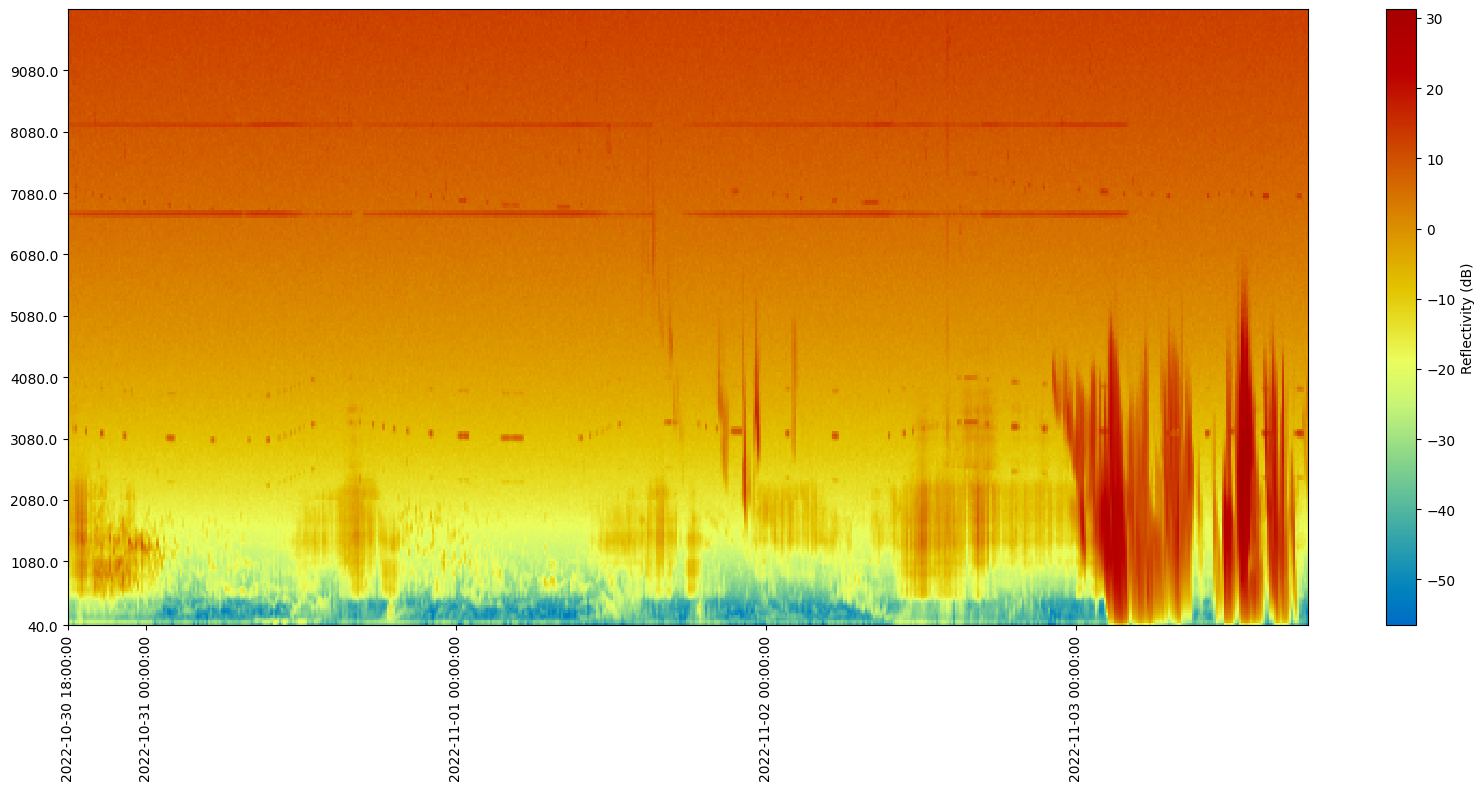

In [8]:
obj_src = obj1_kps.resample(time='10min').mean()

df = obj_src.to_dataframe().reset_index().drop(columns='file').drop_duplicates()
# #convert from utc to mountain
df['time'] = df['time'] - datetime.timedelta(hours=6)

time_ticks_df = df[['time']].drop_duplicates().sort_values('time').reset_index(drop=True).reset_index()
time_ticks_df = time_ticks_df.groupby([time_ticks_df['time'].dt.day]).first()

space_ticks_df = df[['range']].drop_duplicates().sort_values('range').reset_index(drop=True).reset_index()
space_ticks_df = pd.concat([df.head(1) for df in np.array_split(space_ticks_df, 10)])

plt.figure(figsize=(20,8))
plt.pcolormesh(
    obj_src['reflectivity_uncalibrated'].transpose().values,
    cmap='act_HomeyerRainbow'
)

plt.xticks(time_ticks_df['index'], time_ticks_df['time'], rotation='vertical')
plt.yticks(space_ticks_df['index'], space_ticks_df['range'])
plt.colorbar(label='Reflectivity (dB)')
plt.show()

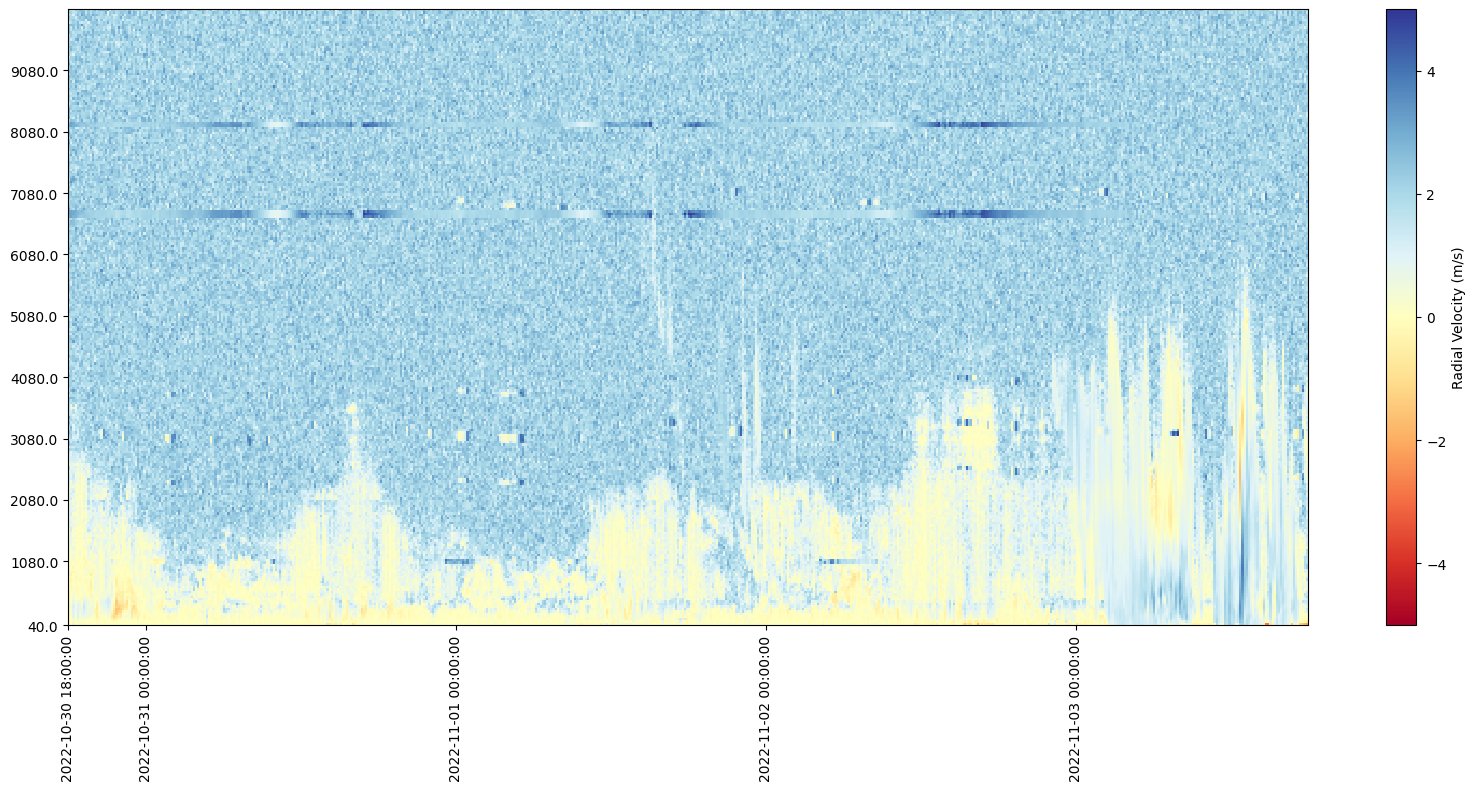

In [9]:
obj_src = obj1_kps.resample(time='10min').mean()

df = obj_src.to_dataframe().reset_index().drop(columns='file').drop_duplicates()
# #convert from utc to mountain
df['time'] = df['time'] - datetime.timedelta(hours=6)

time_ticks_df = df[['time']].drop_duplicates().sort_values('time').reset_index(drop=True).reset_index()
time_ticks_df = time_ticks_df.groupby([time_ticks_df['time'].dt.day]).first()

space_ticks_df = df[['range']].drop_duplicates().sort_values('range').reset_index(drop=True).reset_index()
space_ticks_df = pd.concat([df.head(1) for df in np.array_split(space_ticks_df, 10)])

plt.figure(figsize=(20,8))
plt.pcolormesh(
    obj_src['radial_velocity'].transpose().values,
    cmap='RdYlBu',
    vmin=-5, vmax=5
)

plt.xticks(time_ticks_df['index'], time_ticks_df['time'], rotation='vertical')
plt.yticks(space_ticks_df['index'], space_ticks_df['range'])
plt.colorbar(label='Radial Velocity (m/s)',)
plt.show()

# Download Parcivel data

In [10]:
# Read in the parsivel files from NOAA's webpage.
urls = []

for date in dates:
    for hr in hours:
        urls.append(f"https://downloads.psl.noaa.gov/psd2/data/realtime/DisdrometerParsivel/Stats/kps/{date.year}/{date.strftime('%j')}/kps{date.strftime('%y')}{date.strftime('%j')}{'{:02d}'.format(hr)}_stats.txt")

In [11]:
obj2_kps = act.io.noaapsl.read_psl_parsivel(urls)

In [12]:
obj2_kps

<xarray.Dataset>
Dimensions:                        (time: 2874, particle_size: 32)
Coordinates:
  * time                           (time) datetime64[ns] 2022-10-31 ... 2022-...
  * particle_size                  (particle_size) float64 0.062 0.187 ... 24.5
Data variables: (12/59)
    B1                             (time) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    B2                             (time) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    B3                             (time) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    B4                             (time) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    B5                             (time) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    B6                             (time) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    ...                             ...
    number_non_rain_particles      (time) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    number_ambiguous_particles     (time) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    precip_type                    (time) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    number_density_drops           (time, particle_size) int64 0 0 0 0 ... 0 0 0
    class_size_width               (particle_size) float64 0.125 0.125 ... 3.0
    interval_end_time              (time) datetime64[ns] 2022-10-31T00:02:00 ...

In [13]:
example_parsivel = obj2_kps.to_dataframe().reset_index()[['time', 'particle_size', 'number_density_drops']]

In [14]:
example = obj1_kps.to_dataframe().reset_index().sort_values('time').query('range < 200').drop(columns='file').drop_duplicates()[['time', 'range', 'elevation', 'azimuth', 'reflectivity_uncalibrated', 'radial_velocity', 'snr']]
example.head(100)

: 

: 

In [ ]:
alt.Chart(example).mark_line().encode(
    alt.X('time:T', axis = alt.Axis(format = ("%H%M"))),
    alt.Y('reflectivity_uncalibrated:Q'),
    alt.Color('range:O', title='Altitude above radar (m)')
).properties(width=1400, height=400) & alt.Chart(example_parsivel).mark_line().encode(
    alt.X('time:T'),
    alt.Y('number_density_drops:Q'),
    alt.Color('particle_size:Q')
).properties(width=1400, height=200)

In [ ]:
# First we plot the NOAA FMCW and parsivel from the KPS site

# Create display object with both datasets
display = act.plotting.TimeSeriesDisplay(
    {"NOAA Site KPS PSL Radar FMCW": obj1_kps, "NOAA Site KPS Parsivel": obj2_kps},
    subplot_shape=(2,), figsize=(10, 10))

# Plot the subplots
display.plot('reflectivity_uncalibrated', dsname='NOAA Site KPS PSL Radar FMCW',
             cmap='act_HomeyerRainbow', subplot_index=(0,))
display.plot('number_density_drops', dsname='NOAA Site KPS Parsivel',
             cmap='act_HomeyerRainbow', subplot_index=(1,))
# Set limits
display.axes[1].set_ylim([0, 10])
plt.show()



NameError: name 'act' is not defined

In [ ]:
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

## KAZR data

In [ ]:
#Specify datastream and date range for KAZR data
ds_kazr = 'guckazrcfrgeM1.a1'
startdate = '2022-02-13'
enddate = '2022-02-13'

# Data already retrieved, but showing code below on how to download the files.
act.discovery.download_data(username, token, ds_kazr, startdate, enddate)

# Index last 2 files for the 22:00 and 23:00 timeframe.
kazr_files = glob.glob(''.join(['./',ds_kazr,'/*nc']))
kazr_files[-2:]
kazr = act.io.armfiles.read_netcdf(kazr_files[-2:])

In [ ]:
src = kazr.to_dataframe().reset_index()

(
    len(src['time'].unique()), 
    len(src['range'].unique()), 
    len(src['elevation'].unique()), 
    len(src['azimuth'].unique())
),
(
    src['time'].unique(), 
    src['range'].unique(), 
    src['elevation'].unique(), 
    src['azimuth'].unique()
)

## Laser Disdrometer data

In [ ]:
ds_ld = 'gucldM1.b1'

# Data already retrieved, but showing code below on how to download the files.
act.discovery.download_data(username, token, ds_ld, startdate, enddate)

# Index last 2 files for the 22:00 and 23:00 timeframe.
ld_files = glob.glob(''.join(['./',ds_ld,'/*cdf']))
ld = act.io.armfiles.read_netcdf(ld_files[0])

In [ ]:
# We now want to plot and compare ARM and NOAA's instruments.

# Create a series display with all 4 datasets
display = act.plotting.TimeSeriesDisplay(
    {"NOAA KPS PSL Radar FMCW": obj1_kps, "NOAA KPS Parsivel": obj2_kps,
     "guckazrcfrgeM1.a1": kazr, 'gucldM1.b1': ld},
    subplot_shape=(2, 2), figsize=(22, 12))

# Set custom 2 line title for space
title = "NOAA KPS PSL Radar FMCW\n reflectivity_uncalibrated on 20220213"

# Plot the four subplots
display.plot('reflectivity_uncalibrated', dsname='NOAA KPS PSL Radar FMCW',
             cmap='act_HomeyerRainbow', set_title=title, subplot_index=(0, 1))
display.plot('number_density_drops', dsname='NOAA KPS Parsivel',
             cmap='act_HomeyerRainbow', subplot_index=(1, 1))
display.plot('reflectivity', dsname='guckazrcfrgeM1.a1',
             cmap='act_HomeyerRainbow', subplot_index=(0, 0))
display.plot('number_density_drops', dsname='gucldM1.b1',
             cmap='act_HomeyerRainbow', subplot_index=(1, 0))

# Update limits
display.axes[1, 0].set_ylim([0, 10])

display.axes[1, 1].set_ylim([0, 10])


display.axes[0, 0].set_ylim([0, 10000])
display.axes[0, 0].set_yticklabels(['0', '2', '4','6', '8', '10'])
display.axes[0, 0].set_ylabel('km')

display.axes[0, 1].set_ylim([0, 10000])
display.axes[0, 1].set_yticklabels(['0', '2', '4','6', '8', '10'])
display.axes[0, 1].set_ylabel('km')

plt.show()



# Doppler LIDAR Data

In [6]:
username = 'eschwat'
token = input()

In [7]:
#Specify datastream and date range for KAZR data - the original example from this NB
ds_dl = 'gucdlppiM1.b1'

# 3 datastreams mentioned by Dan Feldman
# ds_dl = 'gucdlrhi2M1.b1'
# ds_dl = 'gucdlrhiM1.b1'
# ds_dl = 'gucdlppiM1.b1'

# startdate = '2022-02-13'
# enddate = '2022-02-13'
startdate = '2022-10-31'
enddate = '2022-11-4'

act.discovery.download_data(username, token, ds_dl, startdate, enddate)

[DOWNLOADING] gucdlppiM1.b1.20221101.001503.cdf
[DOWNLOADING] gucdlppiM1.b1.20221101.003002.cdf
[DOWNLOADING] gucdlppiM1.b1.20221101.004502.cdf
[DOWNLOADING] gucdlppiM1.b1.20221101.020022.cdf
[DOWNLOADING] gucdlppiM1.b1.20221101.021503.cdf
[DOWNLOADING] gucdlppiM1.b1.20221101.031503.cdf
[DOWNLOADING] gucdlppiM1.b1.20221101.033002.cdf
[DOWNLOADING] gucdlppiM1.b1.20221101.034502.cdf
[DOWNLOADING] gucdlppiM1.b1.20221101.040021.cdf
[DOWNLOADING] gucdlppiM1.b1.20221101.041502.cdf
[DOWNLOADING] gucdlppiM1.b1.20221101.043002.cdf
[DOWNLOADING] gucdlppiM1.b1.20221101.051502.cdf
[DOWNLOADING] gucdlppiM1.b1.20221101.060022.cdf
[DOWNLOADING] gucdlppiM1.b1.20221101.063002.cdf
[DOWNLOADING] gucdlppiM1.b1.20221101.064502.cdf
[DOWNLOADING] gucdlppiM1.b1.20221101.073003.cdf
[DOWNLOADING] gucdlppiM1.b1.20221101.080022.cdf
[DOWNLOADING] gucdlppiM1.b1.20221101.081503.cdf
[DOWNLOADING] gucdlppiM1.b1.20221101.083003.cdf
[DOWNLOADING] gucdlppiM1.b1.20221101.084502.cdf
[DOWNLOADING] gucdlppiM1.b1.20221101.090

['/Users/elischwat/Development/sublimationofsnow/analysis/gucdlppiM1.b1/gucdlppiM1.b1.20221101.001503.cdf',
 '/Users/elischwat/Development/sublimationofsnow/analysis/gucdlppiM1.b1/gucdlppiM1.b1.20221101.003002.cdf',
 '/Users/elischwat/Development/sublimationofsnow/analysis/gucdlppiM1.b1/gucdlppiM1.b1.20221101.004502.cdf',
 '/Users/elischwat/Development/sublimationofsnow/analysis/gucdlppiM1.b1/gucdlppiM1.b1.20221101.020022.cdf',
 '/Users/elischwat/Development/sublimationofsnow/analysis/gucdlppiM1.b1/gucdlppiM1.b1.20221101.021503.cdf',
 '/Users/elischwat/Development/sublimationofsnow/analysis/gucdlppiM1.b1/gucdlppiM1.b1.20221101.031503.cdf',
 '/Users/elischwat/Development/sublimationofsnow/analysis/gucdlppiM1.b1/gucdlppiM1.b1.20221101.033002.cdf',
 '/Users/elischwat/Development/sublimationofsnow/analysis/gucdlppiM1.b1/gucdlppiM1.b1.20221101.034502.cdf',
 '/Users/elischwat/Development/sublimationofsnow/analysis/gucdlppiM1.b1/gucdlppiM1.b1.20221101.040021.cdf',
 '/Users/elischwat/Developme

In [8]:
dl_ppi_files = glob.glob(''.join(['./',ds_dl,'/*cdf']))

# Index last 9 files for the 22:00 and 23:00 timeframe.
# dl_ppi = act.io.armfiles.read_netcdf(dl_ppi_files[-9:])

# Or use this?
dl_ppi = act.io.armfiles.read_netcdf(dl_ppi_files)

# Calculate the winds from the gucdlppi dataset.
wind_obj = act.retrievals.compute_winds_from_ppi(
    dl_ppi, remove_all_missing=True, snr_threshold=0.002)

In [ ]:
len(wind_obj.to_dataframe().reset_index().to_pickle("kp_radar_windspeed.pickle"))

In [ ]:
dl_ppi_files = glob.glob(''.join(['./',ds_dl,'/*cdf']))

# Index last 9 files for the 22:00 and 23:00 timeframe.
dl_ppi = act.io.armfiles.read_netcdf(dl_ppi_files[-9:])

# Or use this?
# dl_ppi = act.io.armfiles.read_netcdf(dl_ppi_files)

# Calculate the winds from the gucdlppi dataset.
wind_obj = act.retrievals.compute_winds_from_ppi(
    dl_ppi, remove_all_missing=True, snr_threshold=0.002)

In [ ]:
len(wind_obj.to_dataframe().reset_index().to_pickle("kp_radar_windspeed.pickle"))

In [ ]:
alt.Chart(
    wind_obj.to_dataframe().reset_index()
).transform_filter(alt.datum.height < 50).mark_line(point=True).encode(
    alt.X('time:T'),
    alt.Y('wind_direction:Q'),
    alt.Color('height:N'),
).properties(width=1000) & alt.Chart(
    wind_obj.to_dataframe().reset_index()
).transform_filter(alt.datum.height < 50).mark_line(point=Tårue).encode(
    alt.X('time:T'),
    alt.Y('wind_speed:Q'),
    alt.Color('height:N'),
).properties(width=1000)

In [ ]:
display.plot_barbs_from_spd_dir('wind_speed', 'wind_direction',
                                dsname='GUC DLPPI Computed Winds over KAZR',
                                invert_y_axis=False)

In [ ]:
spd = wind_obj['wind_speed']
dir = wind_obj['wind_direction']
tempu = -np.sin(np.deg2rad(dir)) * spd
tempv = -np.cos(np.deg2rad(dir)) * spd


In [ ]:
# Create a display object.
display = act.plotting.TimeSeriesDisplay(
    {"GUC DLPPI Computed Winds over KAZR": wind_obj,
     "guckazrcfrgeM1.a1": kazr,}, figsize=(20, 10))

# Plot the wind barbs overlayed on the KAZR reflectivity
display.plot('reflectivity', dsname='guckazrcfrgeM1.a1',
             cmap='act_HomeyerRainbow', 
            #  vmin=-20, 
            #  vmax=30
            )
display.plot_barbs_from_spd_dir('wind_speed', 'wind_direction',
                                dsname='GUC DLPPI Computed Winds over KAZR',
                                invert_y_axis=False)

# Update the x-limits to make sure both wind profiles are shown
display.axes[0].set_xlim([np.datetime64('2022-02-13T22:10'), np.datetime64('2022-02-13T23:50')])
plt.show()

In [ ]:
import xarray

In [ ]:
import netCDF4 as nc
fn = '/Volumes/noqc_geo/isfs_20221031.nc'
ds = nc.Dataset(fn)

In [ ]:
import rioxarray as rix

In [ ]:
conda install -c conda-forge rioxarray